In [1]:
import os, sys

# 1) Set notebook working directory = FaceStats project root
PROJECT_ROOT = "/Users/jayklarin/__DI/Repositories/FaceStats"
os.chdir(PROJECT_ROOT)
print("cwd:", os.getcwd())

# 2) Add src/ folder to Python PATH
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

print("src path added:", SRC_PATH)


cwd: /Users/jayklarin/__DI/Repositories/FaceStats
src path added: /Users/jayklarin/__DI/Repositories/FaceStats/src


In [2]:
import polars as pl

# ============================================================
# Step 1 — Load Full Attribute Table
# ============================================================

ATTR_PATH = "data/processed/metadata/attractiveness_with_attributes.parquet"

print("Loading full dataset…")
df = pl.read_parquet(ATTR_PATH)

print("Loaded dataset:", df.shape)
print(df.head())


Loading full dataset…
Loaded dataset: (10000, 6)
shape: (5, 6)
┌───────────────────────┬──────────────┬──────┬──────────────┬─────────────────┬────────────────┐
│ filename              ┆ embedding    ┆ age  ┆ gender_final ┆ ethnicity_final ┆ attractiveness │
│ ---                   ┆ ---          ┆ ---  ┆ ---          ┆ ---             ┆ ---            │
│ str                   ┆ list[f64]    ┆ null ┆ str          ┆ str             ┆ f32            │
╞═══════════════════════╪══════════════╪══════╪══════════════╪═════════════════╪════════════════╡
│ SFHQ_pt4_00086092.jpg ┆ [0.040853,   ┆ null ┆ unknown      ┆ unknown         ┆ 3.161696       │
│                       ┆ -0.001176, … ┆      ┆              ┆                 ┆                │
│                       ┆ -0.034…      ┆      ┆              ┆                 ┆                │
│ SFHQ_pt4_00065309.jpg ┆ [0.030933,   ┆ null ┆ female       ┆ unknown         ┆ 3.037134       │
│                       ┆ 0.005503, …  ┆      ┆        

In [3]:
# Merge geometry-based attractiveness if available
try:
    df_meta = pl.read_parquet("data/processed/metadata/attributes_with_meta.parquet")
    if "attractiveness_geom" in df_meta.columns:
        df = df.join(df_meta.select(["filename", "attractiveness_geom"]), on="filename", how="left")
        print("Merged attractiveness_geom from attributes_with_meta.parquet")
    else:
        print("attributes_with_meta.parquet has no attractiveness_geom column")
except FileNotFoundError:
    print("attributes_with_meta.parquet not found; run the FaceMesh notebook first.")


Merged attractiveness_geom from attributes_with_meta.parquet


/var/folders/gz/0c41mw6j22x4rm3rkhgx2_3h0000gn/T/ipykernel_21282/3885599193.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


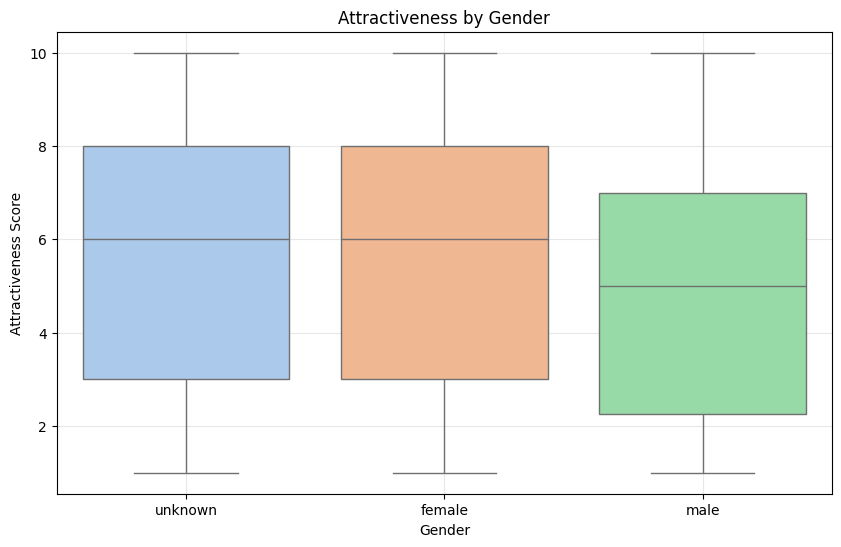

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to pandas for easy plotting
pdf = df.to_pandas()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=pdf,
    x="gender_final",
    y="attractiveness_geom",
    palette="pastel"
)

plt.title("Attractiveness by Gender")
plt.xlabel("Gender")
plt.ylabel("Attractiveness Score")
plt.grid(alpha=0.3)
plt.show()


/var/folders/gz/0c41mw6j22x4rm3rkhgx2_3h0000gn/T/ipykernel_21282/1211324551.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


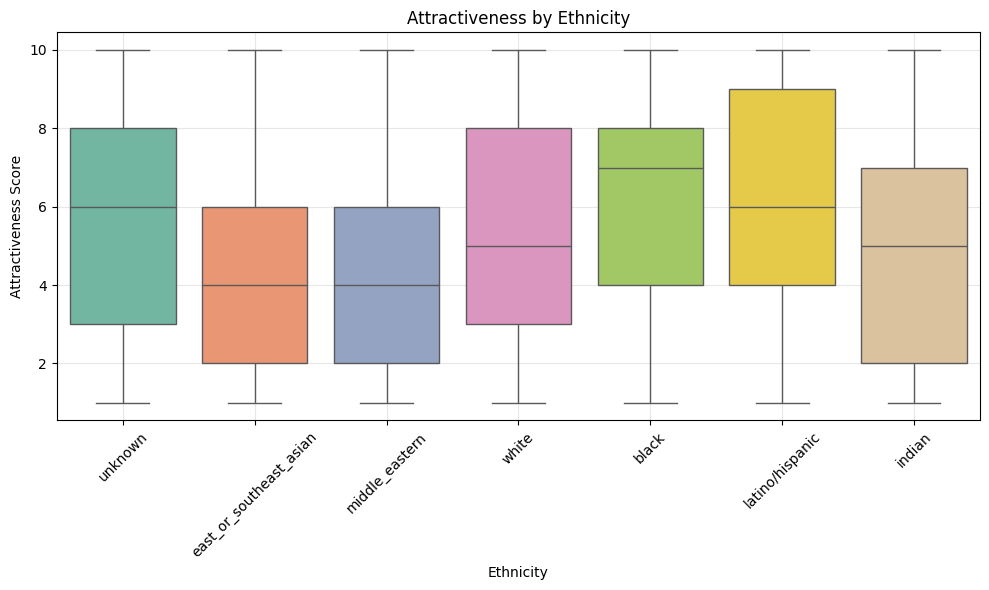

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df.to_pandas(),
    x="ethnicity_final",
    y="attractiveness_geom",
    palette="Set2"
)

plt.xticks(rotation=45)
plt.xlabel("Ethnicity")
plt.ylabel("Attractiveness Score")
plt.title("Attractiveness by Ethnicity")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


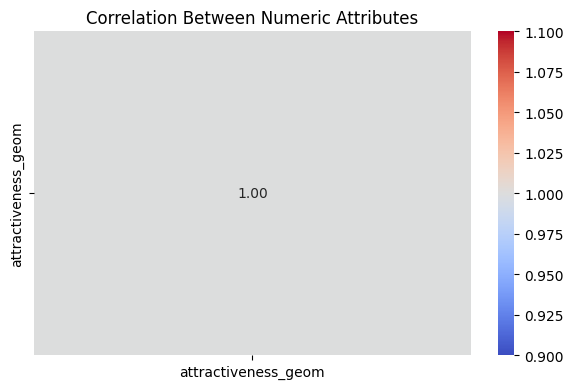

In [6]:
# ============================================================
# Step 4 — Correlation Matrix of Attributes
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Polars → Pandas for seaborn
df_pd = df.to_pandas()

# Select numeric columns only
numeric_cols = ["attractiveness_geom"]

# Only include age if we later populate it
if "age" in df_pd.columns:
    if df_pd["age"].notna().any():
        numeric_cols.append("age")

# Build correlation matrix
corr = df_pd[numeric_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numeric Attributes")
plt.tight_layout()
plt.show()


Preparing PCA...
Running PCA...


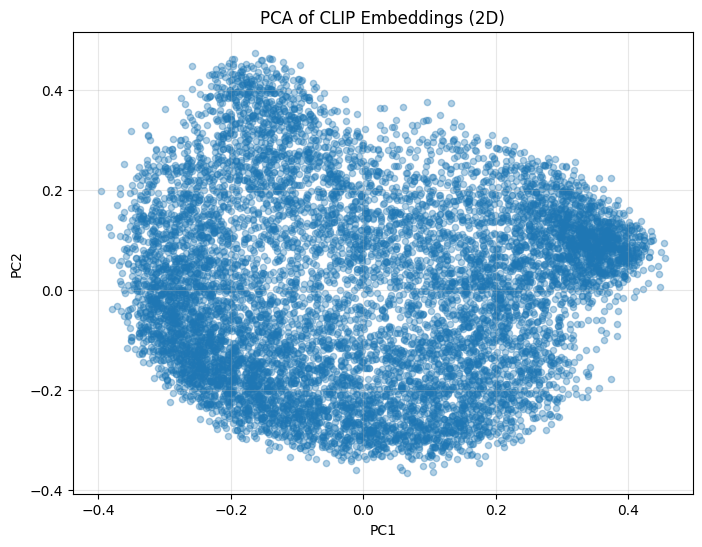

In [7]:
# ============================================================
# Step 5 — PCA Visualization of Embeddings (2D)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print("Preparing PCA...")

# Convert embeddings (list[f64]) into a numpy matrix
X = np.vstack(df_pd["embedding"].to_list())

print("Running PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Add PCA coords back to DataFrame for plotting
df_pd["pca_x"] = X_pca[:, 0]
df_pd["pca_y"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(df_pd["pca_x"], df_pd["pca_y"], s=20, alpha=0.35)
plt.title("PCA of CLIP Embeddings (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.show()


In [8]:
from sklearn.decomposition import PCA
import numpy as np
import polars as pl

print("Preparing PCA…")

# Extract 512-D vectors as a numpy matrix
X = np.vstack(df["embedding"].to_list())

print("Running PCA…")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Build df_pca (Polars)
df_pca = df.with_columns([
    pl.Series("PC1", X_pca[:, 0]),
    pl.Series("PC2", X_pca[:, 1]),
])

# Convert to pandas for seaborn/matplotlib
df_pca = df_pca.to_pandas()

df_pca.head()


Preparing PCA…
Running PCA…


filename                                          embedding  \
0  SFHQ_pt4_00086092.jpg  [0.04085291922092438, -0.0011762173380702734, ...   
1  SFHQ_pt4_00065309.jpg  [0.030933307483792305, 0.005502537824213505, 0...   
2  SFHQ_pt4_00062466.jpg  [0.07131921499967575, -0.005248620640486479, -...   
3  SFHQ_pt4_00090828.jpg  [0.06619927287101746, -0.0035423440858721733, ...   
4  SFHQ_pt4_00032251.jpg  [0.02125166729092598, -0.06064509600400925, -0...   

    age gender_final ethnicity_final  attractiveness  attractiveness_geom  \
0  None      unknown         unknown        3.161696                  6.0   
1  None       female         unknown        3.037134                  6.0   
2  None      unknown         unknown        2.769664                  9.0   
3  None      unknown         unknown        2.987006                  9.0   
4  None      unknown         unknown        3.152438                  4.0   

        PC1       PC2  
0  0.085275  0.145240  
1  0.382363  0.103739  
2  0.181280 -0.179124  
3  0.121787  0.035100  
4 -0.011792 -0.198607

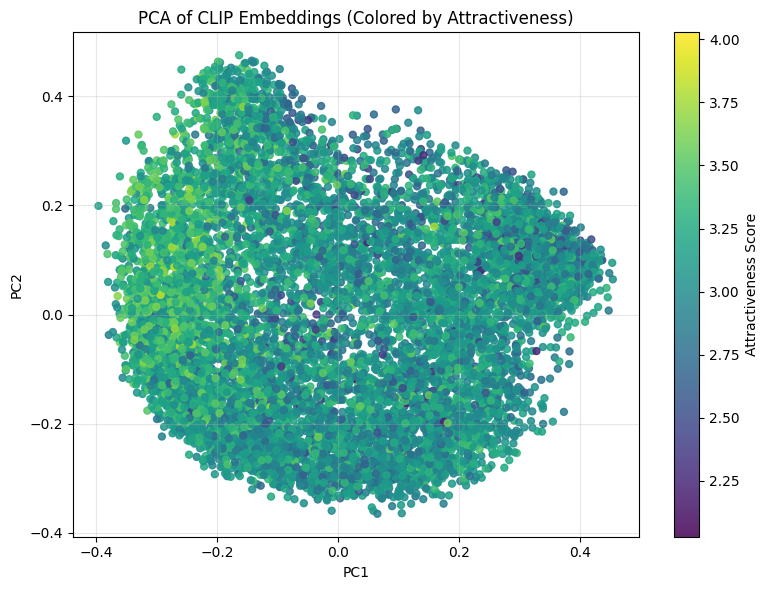

In [9]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# PCA colored by attractiveness
# ------------------------------------------------------------
x = df_pca["PC1"].to_numpy()
y = df_pca["PC2"].to_numpy()
attr = df_pca["attractiveness"].to_numpy()

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    x, y,
    c=attr,
    cmap="viridis",
    s=25,
    alpha=0.85
)

plt.colorbar(sc, label="Attractiveness Score")
plt.title("PCA of CLIP Embeddings (Colored by Attractiveness)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


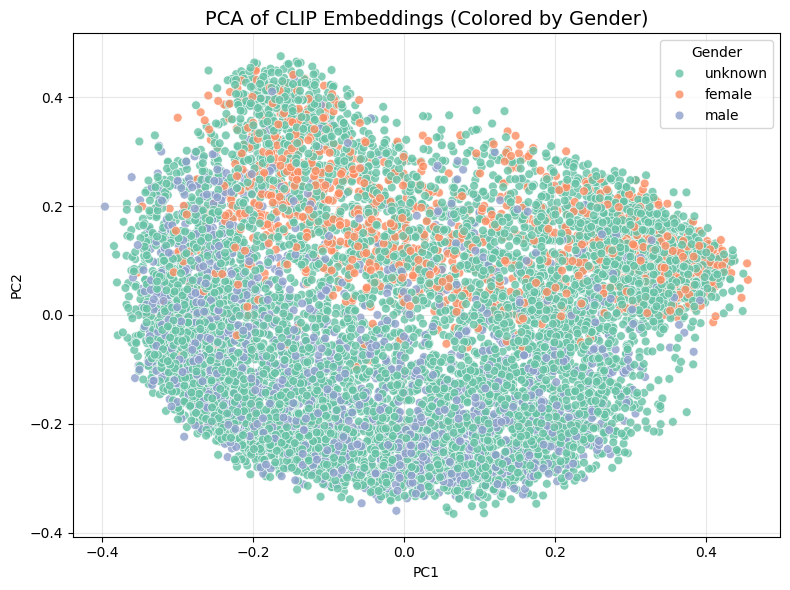

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out unknown genders for cleaner visualization (optional)
df_plot = df_pca.copy()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot,
    x="PC1",
    y="PC2",
    hue="gender_final",
    palette="Set2",
    s=40,
    alpha=0.8
)

plt.title("PCA of CLIP Embeddings (Colored by Gender)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = df_pca.copy()

plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=df_plot,
    x="PC1",
    y="PC2",
    hue="ethnicity_final",
    palette="tab10",
    s=40,
    alpha=0.8
)

plt.title("PCA of CLIP Embeddings (Colored by Ethnicity)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Geometry-based attractiveness distribution (attractiveness_geom)

In [12]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

meta_path = 'data/processed/metadata/attributes_final.parquet'
scores_path = 'data/processed/metadata/attractiveness_scores.parquet'
geom_path = 'data/processed/metadata/attributes_with_meta.parquet'

try:
    df = pd.read_parquet(meta_path)
except FileNotFoundError:
    print(f'Missing {meta_path}; cannot plot attractiveness.')
else:
    # merge scores
    try:
        df_scores = pd.read_parquet(scores_path)
        df = df.merge(df_scores, on='filename', how='left')
    except FileNotFoundError:
        print(f'Missing {scores_path}; skipping score merge.')

    # coalesce from geom if needed
    if 'attractiveness' not in df.columns and 'attractiveness_geom' in df.columns:
        df['attractiveness'] = df['attractiveness_geom']

    if 'attractiveness' in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df['attractiveness'].dropna(), bins=10, color='skyblue')
        plt.title('Attractiveness distribution (1–10)')
        plt.xlabel('score')
        plt.ylabel('count')
        plt.tight_layout()
        plt.show()
    else:
        print('No attractiveness column available to plot.')

    # Optional geometry buckets
    try:
        df_geom = pd.read_parquet(geom_path)
        if 'attractiveness_geom' in df_geom.columns:
            plt.figure(figsize=(6,4))
            sns.countplot(x='attractiveness_geom', data=df_geom, order=sorted(df_geom['attractiveness_geom'].dropna().unique()))
            plt.title('Geometry-based attractiveness (1–10)')
            plt.xlabel('attractiveness_geom')
            plt.ylabel('count')
            plt.tight_layout()
            plt.show()
    except FileNotFoundError:
        pass


No attractiveness column available to plot.


### Sample faces by geometry-based attractiveness (3 per decile)

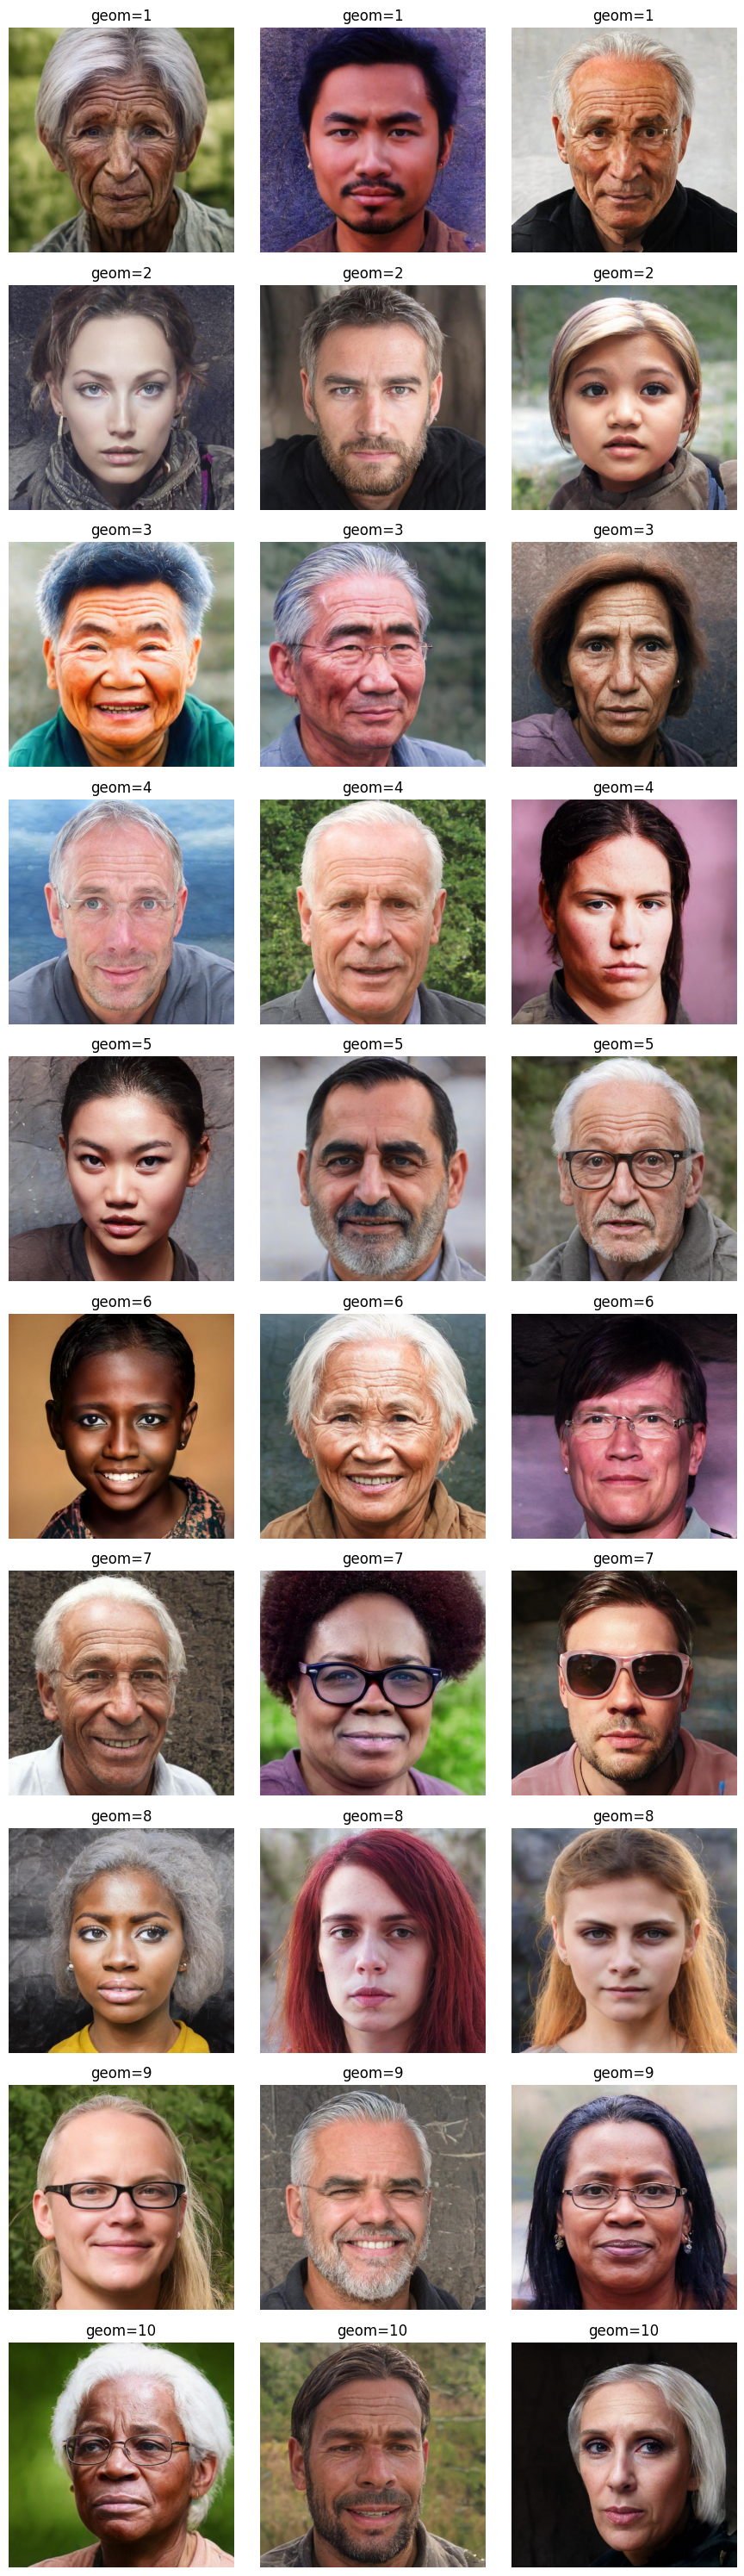

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

meta_path = 'data/processed/metadata/attributes_with_meta.parquet'
preproc_dir = Path('data/processed/preproc')
try:
    df_meta = pd.read_parquet(meta_path)
except FileNotFoundError:
    print(f'Missing {meta_path}; run the FaceMesh notebook first.')
else:
    if 'attractiveness_geom' not in df_meta.columns:
        print('No attractiveness_geom column; skip sampling')
    else:
        # pick up to 3 faces per label 1–10
        samples = []
        for label in range(1, 11):
            sub = df_meta[df_meta['attractiveness_geom'] == label]
            if sub.empty:
                continue
            samples.append(sub.sample(n=min(3, len(sub)), random_state=42))
        if not samples:
            print('No samples found for any label')
        else:
            df_samples = pd.concat(samples)
            n = len(df_samples)
            cols = 3
            rows = (n + cols - 1) // cols
            plt.figure(figsize=(3*cols, 3*rows))
            for i, row in df_samples.reset_index(drop=True).iterrows():
                img_path = preproc_dir / row['filename']
                plt.subplot(rows, cols, i+1)
                if img_path.exists():
                    img = plt.imread(img_path)
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title(f"geom={row['attractiveness_geom']}")
                else:
                    plt.text(0.5, 0.5, 'missing', ha='center')
                    plt.axis('off')
            plt.tight_layout()
            plt.show()
